In [5]:

# =============================================================================
# Import Libraries
# =============================================================================
import random
import operator
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [14]:
# =============================================================================
# # Decision Tree Classifier
# =============================================================================
# Gini calculation:
def gini(y):
    if len(y) < 1:
        return 0
    values, counts = np.unique(y, return_counts=True)
    g = 1. - np.sum((counts / len(y))**2)
    return g

# Create node class:
class node:
    def __init__(self, threshold = 0.5):
        self._leaf = True
        self._label = -1
        self._threshold = threshold
        pass
    def fit(self, X, y):
        g = gini(y)
        c = X.shape[0]
        if g < self._threshold:
            values, counts = np.unique(y, return_counts=True)
            self._label = values[np.argmax(counts)]
            return self
        self._leaf = False
        self._k = -1
        self._pred = 0
        self._ig = -100
        for k in range(X.shape[1]):
            vmin = X[:,k].min()
            vmax = X[:,k].max()
            for p in np.linspace(vmin, vmax):
                split = X[:, k] > p
                g1 = gini(y[split])
                g2 = gini(y[np.logical_not(split)])
                c1 = np.sum(split)
                c2 = c - c1
                ig = g - c1 / c * g1 - c2 / c * g2
                if ig > self._ig:
                    self._ig = ig
                    self._pred = p
                    self._k = k
                    
        if self._ig < 0.0001:
            self._leaf = True
            values, counts = np.unique(y, return_counts=True)
            self._label = values[np.argmax(counts)]
            return self            

        split = X[:, self._k] > self._pred
        self._bigger = node(threshold=self._threshold)
        self._bigger.fit(X[split], y[split])
        split2 = np.logical_not(split)
        self._less = node(threshold=self._threshold)
        self._less.fit(X[split2], y[split2])
        return self
    def predict(self, sample):
        if self._leaf:
            return self._label
        else:
            if sample[self._k] > self._pred:
                return self._bigger.predict(sample)
            else:
                return self._less.predict(sample)

# Decision tree Classifier class:
class decision_tree(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold = 0.1):
        self._threshold = threshold
    def fit(self, X, y):
        self._root = node(threshold=self._threshold)
        self._root.fit(X, y)
        return self
    def predict(self, sample):
        return [self.predict_one(s) for s in sample]
    def predict_one(self, sample):
        return self._root.predict(sample)
    

In [9]:

# =============================================================================
# # Construct datasets 
# =============================================================================
X_big, y_big = make_classification(n_samples=5000)
X_small, y_small = make_classification(n_samples=700)

X_big_train, X_big_test, y_big_train, y_big_test = train_test_split(X_big, y_big, test_size=0.3)
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, test_size=0.3)


In [11]:
# =============================================================================
# # Constructs bootstrap sample by given sample matrix X and label matrix y
# # return bootstrap sample and corresponding labels
# =============================================================================
def get_bootstrap_sample(X, y):
    X_bootstrap = []
    y_bootstrap = []
    for i in range(len(X)):
        index = random.choice(range(len(X)))
        X_bootstrap.append(X[index])
        y_bootstrap.append(y[index])
    return X_bootstrap, y_bootstrap


In [12]:

# =============================================================================
# Bagging Classifier
# =============================================================================
class BaggingAlgorithm(BaseEstimator, ClassifierMixin):
    
    def __init__(self, n_samples=3, algorithm=decision_tree()):
        """Initiate Bagging algorithm object.
        :param n_samples: number of algorithms in bagging ensamble
        :param algorithm: type of algorithm to be bagged
        classif - list of self.algorithm type objects trained during fitting bagging"""
        self.n_samples = n_samples
        self.classif = []
        self.algorithm = algorithm
        
    def fit(self, X, y):
        """Construct n_samples bootstrap samples from X, then train n_samples algorithms of self.algorithm type
        Save trained algorithms in self.classif list
        :param X: matrix of elements
        :param y: vector of labels
        :return : self"""
        X_boot = []
        y_boot = []
        for i in range(self.n_samples):
            X_b, y_b = get_bootstrap_sample(X, y)
            curr_alg = self.algorithm.fit(X, y)
            self.classif.append(curr_alg)
        return self
    
    def predict(self, X):
        """Get prediction by algorithms in self.classif list. Then get resulting labels by voting: if more than a half of
        algorithms voted 1, then resulting label is 1, else 0.
        :param X: matrix of samples to be predicted
        :return : list of labels for X"""
        predictions = np.zeros((self.n_samples, len(X)))
        for i in range(self.n_samples):
            predictions[i] = self.classif[i].predict(X)
        res = np.sum(predictions, axis=0)
        return [1 if res[i]>=self.n_samples/2 else 0 for i in range(len(X))]

In [15]:
   
# =============================================================================
# # Test bagging on small dataset
# =============================================================================  
# Finding the Right Number of n_sample
parameters_rf = range(1, 20, 5)
errors = []

# Investigate the dependence of the test error on the number of estimators 
# in the ensemble.
for i in range(len(parameters_rf)):
    rf = BaggingAlgorithm(n_samples=parameters_rf[i]).fit(X_small_train, y_small_train)
    errors.append(accuracy_score(rf.predict(X_small_test), y_small_test))
    print(parameters_rf[i], '  th fitted and predicted')



1   th fitted and predicted
6   th fitted and predicted
11   th fitted and predicted
16   th fitted and predicted


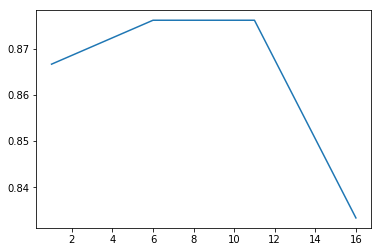

In [16]:
# ploting the error = f(parameters_rf)  
plt.plot(parameters_rf, errors)
plt.show()


In [17]:
# n_sample = 3 ##a voir avec test
bg = BaggingAlgorithm(n_samples=3)
bg.fit(X_small, y_small)

#accuraccy 
accuracy_score(bg.predict(X_small_test), y_small_test)


0.9095238095238095

In [19]:

# =============================================================================
# # Test bagging on big dataset
# =============================================================================

# Finding the Right Number of n_sample
parameters_rf = range(1, 20, 5)
errors = []

# Investigate the dependence of the test error on the number of estimators 
# in the ensemble.
for i in range(len(parameters_rf)):
    rf = BaggingAlgorithm(n_samples=parameters_rf[i]).fit(X_big_train, y_big_train)
    errors.append(accuracy_score(rf.predict(X_big_test), y_big_test))
    print(parameters_rf[i], '  th fitted and predicted')



1   th fitted and predicted
6   th fitted and predicted
11   th fitted and predicted
16   th fitted and predicted


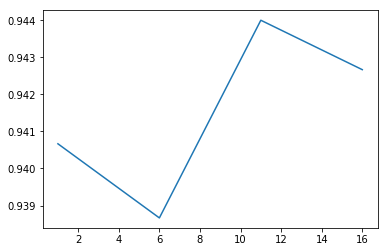

In [20]:
# ploting the error = f(parameters_rf)  
plt.plot(parameters_rf, errors)
plt.show()



In [ ]:
# n_sample = 3
bg = BaggingAlgorithm(n_samples=3)
bg.fit(X_big_train, y_big_train)

#accuraccy 
accuracy_score(bg.predict(X_big_test), y_big_test)


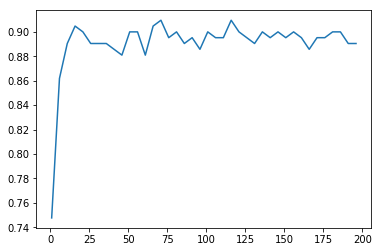

In [21]:
# =============================================================================
# Random forest
# =============================================================================
# Split small dataset and train/test random forest with n_trees from 1 to 200
parameters_rf = range(1, 200, 5)
errors = []

# Investigate the dependence of the test error on the number of trees in the ensemble.
for i in range(len(parameters_rf)):
    rf = RandomForestClassifier(n_estimators=parameters_rf[i]).fit(X_small_train, y_small_train)
    errors.append(accuracy_score(rf.predict(X_small_test), y_small_test))
    
# ploting the error = f(parameters_rf)    
plt.plot(parameters_rf, errors)
plt.show()


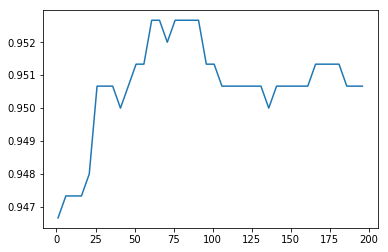

In [22]:

# =============================================================================
# # Gradient boosting
# =============================================================================
# Try on small dataset, number of estimators from 1 to 200
parameters_rf = range(1, 200, 5)
errors = []

# The dependence of the test error on the number of classifiers.
for i in range(len(parameters_rf)):
    rf = GradientBoostingClassifier(n_estimators=parameters_rf[i]).fit(X_big_train, y_big_train)
    errors.append(accuracy_score(rf.predict(X_big_test), y_big_test))
    
plt.plot(parameters_rf, errors)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYQAAAD8CAYAAAB3u9PLAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvNQv5yAAAIABJREFUeJzt3X10XPV95/H3V5Jl2ZbkBz1YlmxsY4xtYbAcFEpKABOS8JDEEtDNQtI2aZvSNuFse7rJFk522S5ZlrQlu21Osu1hG06abVrC0lQywQESF5MEAsFEkh+wZWRjsPVgS/KT5AfJkr77x9xxxrJkjaSZuTPS53WOjmfuvXPvd67k+cz93d/9XXN3REREssIuQERE0oMCQUREAAWCiIgEFAgiIgIoEEREJKBAEBERQIEgIiIBBYKIiAAKBBERCeSEXcB4FBcX+7Jly8IuQ0Qko7z55ptd7l4y1nIZFQjLli1j27ZtYZchIpJRzOzdeJZTk5GIiAAKBBERCSgQREQEUCCIiEhAgSAiIoACQUREAgoEEREBMuw6BMksT/3iPdqOnxl1/qzcHH7nhmXkzcge97p3tp7gxV0dkynvkvJys/ndG5ZPqDaRTKVAkKRoO36GB7+/AwCzi+dHb+VdNCeXT75/ybjX/+W6nTQdPD7iuicrWtvyojnccfWixG9AJE0pECQp9nScBOCZP/wA1csWXDTf3bnl8a3UNbaOOxDe6TpF08HjPHTHav7g5hUJqTfW2XODVD78PLs7ehQIMq3oHIIkxZ6OHgCuLCsYcb6ZUVNVwc/3d9Nx4uy41l3f2IoZbKwqn3SdI8mbkc2y4jk0B6EmMl0oECQp9rT3UDFvFoV5M0ZdpnZ9Be7wbFNb3Ot1d+ob2/i15QtYNHdWIkod0eqygvOhJjJdKBAkKZo7elizaOSjg6jlxXNYt3gudY2tca93+6ETvNN1itqqismWeEmrywp57+hpTvUNJHU7IulEgSAJ1z8wxL7OXlaN0lwUq6aqgl1tJ2k5Et+38brGVnKzs5Letr+qrAB32HtYRwkyfSgQJOH2dfYyMOSsLiscc9mPr1tElkFdw9jNRgODQzzb1M4tq0uYO2v0pqhEWBPU3qxmI5lGFAiScNEeRqvjOEIoLcjjhiuKqW9qxaP9PUfx6r5uunr7kt5cBLB4/ixm52brPIJMKwoESbg9HT3kZmexvHhOXMvXVlVw8OgZfvnesUsuV9fYSkFeDresLk1EmZeUlWWsKis4H24i04ECQRJuT3sPV5Tmk5Md35/XbWvLyJuRdclmozP9g7yws4M71pal7OrhaE+jsY5cRKYKBYIkXHNHT1zNRVH5M3P48JqFPLejnXODQyMu8+PdhznVP5iS5qKo1WWFHD99jiM9fSnbpkiYFAiSUMdP99Nx8iyrx+hyOlxtVQVHT/Xz07c7R5xf39jKwsKZ/NrlRYkoMy7RXlK729VsJNODAkESKnoSdlUcPYxi3XRlCfNmzxix2ejYqX62NneycV052VlJGLxoFNGjHPU0kulCgSAJtSf4Nr1mHE1GALk5Wdx59SJ+9Nbhiy4Ge25HOwNDTk0Km4sA5s3OpawwTz2NZNpQIEhCNR/uYf7sGZQUzBz3a2urKjhzbpAX37pwWOv6xlauKM3nqvLxHXUkwupFGsJCpg8FgiTU7vYeVpcVYhMYl7p66Xwq5s26oNno0LHTvHHgGLVV5RNa52StKiug5UjPqCe7RaYSBYIkzNCQs/dwT1xDVowkK8vYWFXOz1q66OqN9OzZFAx8l+rmoqg1ZYWcG3Te6ToVyvZFUkmBIAlz8NhpTvcPjjmo3aXUVlUwOOQ8t70dgPqGNq5dOp8lC2YnqsxxUU8jmU4UCJIwE+1hFGtVWQGrywqoa2xld/tJmg/3UJuk+x7EY0VJPjlZpp5GMi3EFQhmdruZNZtZi5k9OML8pWa2xcy2m9lWM1scM2/QzBqDn00x078brHOnmT1pZskdrUySbk97D2Zw5cL8Sa2ndn0FDe8d5+tb3iYny/jYNeEFQm5OFitK8nViWaaFMQPBzLKBbwJ3AJXAfWZWOWyxx4HvuPs1wCPAYzHzzrh7VfCzMWb6d4HVwNXALOBzE38bkg6aD59k6YLZzM6d3J1ZN64rxwx+uLODm64sYcGc3ARVODGrFxXoCEGmhXiOEK4DWtx9v7v3A08BNcOWqQS2BI9fGmH+Rdx9sweAXwCLx3qNpLc9QQ+jySqfN4vrgvsw14TYXBS1qqyA1uNnOHHmXNiliCRVPIFQARyMeX4omBarCbgneHwXUGBm0TEG8sxsm5m9Zma1w1ceNBX9FvD8SBs3s/uD12/r7Bx5WAMJ35n+QQ50n5pwD6PhfveDy1mzqJCPVC5MyPomI3pvBN0sR6a6eAJhpM7fw4d//CJws5k1ADcDrUD0ctPL3L0a+BTw12a2Ythr/zfwE3f/6Ugbd/cn3L3a3atLSkriKFfC8PaRHoacSfUwinXbVWX88I9vnHTzUyJEQ26PehrJFBfP/7ZDwJKY54uBCwaccfc24G4AM8sH7nH3EzHzcPf9ZrYVWA/sC5b9r0AJ8AeTehcSukT0MEpXi+bmUZiXoxPLMuXFc4TwBrDSzJabWS5wL7ApdgEzKzaz6LoeAp4Mps83s5nRZYAbgLeC558DbgPuc3ddBprh9rT3kDcji8tCul4gmcyM1WWFCgSZ8sYMBHcfAB4AXgB2A0+7+y4ze8TMor2GNgDNZrYXWAg8GkxfA2wzsyYiJ5u/6u5vBfP+Llj250GX1IcT9aYk9ZoPn2TVwoKUjkaaStGeRrpZjkxlcTXQuvtmYPOwaQ/HPH4GeGaE171KpFvpSOsMv3FYEmZPew+3rkn+rS3DsqqsgN6+AQ4dOxPaVdMiyaYrlWXSOnv66D7Vn5Aup+kq+t50PYJMZQoEmbToh+R4bpuZaaI9jZrV9VSmMAWCTNqejkh3zERdg5CO8mfmsHj+LA1yJ1OaAkEmbU9HDyUFMynKH/9NcTLJ6rJCNRnJlKZAkEnb03FySjcXRa0uK2B/1yn6BgbDLkUkKRQIMikDg0O8fbh3egTCogIGh5yWI71hlyKSFAoEmZQD3afpGxia0j2MolafH8JCzUYyNSkQZFKazw9ZMfWPEJYVzSE3J0s9jWTKUiDIpOzpOEl2lnFF6eRuipMJcrKzWFmar55GMmUpEGRS9nT0sLx4DnkzssMuJSXU00imMgWCTMp06WEUtbqsgCM9fRw91R92KSIJp0CQCevtG+Dg0TPTKxCC+z1EL8YTmUoUCDJhzVP4HgijWaWeRjKFKRBkwqbDGEbDleTPpGhOrs4jyJSkQJAJ29Nx8vwYP9OFmbGqrEBNRjIl6Z4EMqrX9nezeUf7qPO37D7CqrICzKbmTXFGs7qskO++/i4P1+8cdZl1i+dxz7WLU1iVXEr/wBBf3/I2J8+eS9o2Nqwq4UOrFyZt/amgQJARuTv/pW4n7x49zZzc0buU3rG2LIVVpYcPrS7l2e1tPNvUNuL8voEhnvrFQT68ZiFzZ89IcXUykhff6uAbL7Uwd9YMknFTv9P9gzy/s4OfP1Sa0XcNVCDIiN5qP8nbR3r577Vr+c3rl4ZdTlr54Mpi3vjyh0edv+PQCT7xjZ+xeWc79113WQork9HUNbSxsHAmrz54a1I+sJ/b3s4X/umXvLa/mxuuKE74+lNF5xBkRPWNbeRkGR+7elHYpWSctRWFXF4yh7qG1rBLEeD46X5e3nuEjevKk/bt/dY1peTPzMn437kCQS4yOORsamzj5itLmD8nN+xyMo6ZUbOugtffOUrb8TNhlzPtPbejnXODTk1VRdK2kTcjm9uuKuP5nR2cPZe5w6MrEOQir7/TTcfJs9SsT95/oKmupqocgE2jnGeQ1KlvaGNFyRyuKk/u9TK168vp6Rvg3/YcSep2kkmBIBepb2hjTm42H1mT2T0mwrSseA5VS+ZlfBNCpjt07DS/OHCU2qqKpPeG+/UVxZQUzMzo37kCQS5w9twgm3e2c9tVZcy6RO8iGVttVTl7Onp0EVuIokdoyWwuisrOMj5xTTlbmzs5cTp53VuTKa5AMLPbzazZzFrM7MER5i81sy1mtt3MtprZ4ph5g2bWGPxsipn+QLA+N7PMPS0/xWxtPkLP2QE1FyXAx4OTmHWNmfuNMdPVN7TxvsvmcVnR7JRsr3Z9Of2DQ2zeOfr1O+lszEAws2zgm8AdQCVwn5lVDlvsceA77n4N8AjwWMy8M+5eFfxsjJn+CvBh4N3JvAFJrLqGNorzc7lhRVHYpWS84vyZfPCKYjY1tjE05GGXM+3sbj9J8+EealP45ebqirlcXpy5PcziOUK4Dmhx9/3u3g88BdQMW6YS2BI8fmmE+Rdx9wZ3PzCOWiXJTpw5x781H+Hj15STk63WxESoXV9O6/EzbHv3WNilTDt1ja1kp7jrtJlRU5W5Pczi+V9fARyMeX4omBarCbgneHwXUGBm0a+YeWa2zcxeM7PaSVUrSfXCzg76B4ZS+o1qqvtoZRmzZmSr2SjFhoacZxvbuGllMUX5M1O67UzuYRZPIIx0an748e8XgZvNrAG4GWgFBoJ5l7l7NfAp4K/NbMV4CjSz+4NA2dbZ2Tmel8o41TW2sqxoNusWzw27lCljzswcPlK5kM072ukfGAq7nGnjFweO0nbibChfbjK5h1k8gXAIWBLzfDFwQfS5e5u73+3u64EvB9NOROcF/+4HtgLrx1Oguz/h7tXuXl1SUjKel8o4dJw4y8/3d1OTgu55003t+nKOnz7Hy3v1hSZV6htbmZ2bzUcqw+k6nak9zOIJhDeAlWa23MxygXuBTbELmFmxmUXX9RDwZDB9vpnNjC4D3AC8lajiJXGebWrDHTUXJcGNK0tYMCdXzUYp0jcwyHPb2/lo5UJm54YzXFum9jAbMxDcfQB4AHgB2A087e67zOwRM4v2GtoANJvZXmAh8GgwfQ2wzcyaiJxs/qq7vwVgZv/BzA4ROeLYbmZ/n8D3JeNU19jKusVzWV48J+xSppwZ2Vl87OpF/Pitw/Qkcfhlidja3MnJkLtOZ2oPs7i6krj7Zne/0t1XuPujwbSH3X1T8PgZd18ZLPM5d+8Lpr/q7le7+7rg32/FrPPr7r7Y3XPcvdzdP5eMNyhjaznSw662kym5eGe6ql1fTt/AEC/sOhx2KVNefWMrRXNyuTHkUUczsYeZ+hYKdQ1tZBl8fJ1GNk2W9102nyULZlGfYU0Imebk2XP8ePcRPn7NotC7TmdiDzMFwjTn7tQ3tXLDFcWUFuSFXc6UFR0B9ZWWLo70nA27nCnr+aDrdDpcaZ+JPcwUCNPcL987xsGjZ6hVc1HS1a4vZ8jh2abMHNYgE9Q3trK0aDbrl8wLuxQg83qYKRCmubqGNmbmZHHbNLwVZqpdUVrAVeWFajZKksMnz/Lqvm5q1pWnTdfpG1eWMH/2jIxpNlIgTGPnBod4bkc7H65cSP5M3U01FWqqytl+6AT7O3vDLmXKiXad3phGR7szsrP42DWZ08NMnwIh++nbnWxqnPgl7jnZxh/evIKlRePvLvrTtzs5eqpfzUUptHFdBY/9cA9femY7l6dpF987ri7jQ6vHf0HX2XOD/OXzzaF98L3S0sXaikKuKM0PZfujqa2q4B9fe48v/FMDCwsmPozGl25bRWlhcs/zKRBC9sRP9vP6/qMU50/sVpWHe/oA47G7rx73a+sa2pg3ewY3X6krwFOlbG4e977/Ml5uPkJ7Gg5+duLMOV7d182G/1RK1jjvP/zc9naefOUdFhbOJDuEJhsz4/dvvDzl2x3LtUvns2FVCXs7emg5PPErl79wyxUJrGpkCoSQdfX2c9OVxfz9Z94/odf/yVMNbN7Rzn/beBW5OfG3AJ7qG+BHbx3mrvdVjOt1MnkTCe9U+f4vD/GnTzfx5nvHeP+yBeN6bV1jK0sWzOInX7olbdrw04GZ8e3fuS7sMuKiT4KQdfX2UTyJ0Rhr1ldw4sw5tjaP7z6uL77VwZlzg2oukgt89Koy8mZkjXtgtiM9Z3mlpYuadRoLK5MpEEI0NOQcPdU/qUC48YpiiubkUj/O8xB1DW1UzJtF9dL5E962TD35M3P4SGUZz42z7/wPmtoZ8kg3S8lcCoQQHTvdz+CQUzTB8wcAOdlZfPyaRfx4d/y9GLp6+/hZSxcbq8rH3U4sU19tVaTv/E/G0Xe+vrGVq8oLuaK0IImVSbIpEELUfaofYFJHCBBpNuobGOL5nR1xLf+DpjYGh1zNRTKim64cX9/5d7pO0XTohP6epgAFQoi6evqAyQfC+iXzWFo0O+5mo7rGNlaXFbCqTN/m5GLn+87vPkxv38CYy9c1tGIGn1in5qJMp0AIUWdvJBBKCibeZATRcXLKeXVfF0dOXnqcnANdp2g8eFz3PZBLqq2q4Oy5IV4Y46jT3alvbOUDlxdRNldjYWU6BUKIunojTUZFcyZ/z9ea9RUM+dj3ca1vbMMMNurbnFzCtUvns3j+rDGbjZoOneBA92k1F00RCoQQdff2kZNlzJ01Y9LrWlGSz9UVcy/ZbBT9NnfdsgWUz5s16W3K1GVm1FSVjzk6a11DK7k5Wdx+tcbCmgoUCCHq6u2jKD83YT19aqrK2dF6gn2jjJOzo/UE+7tOqblI4lJbFTnq/MEoo7MODA7xg+1t3Lq6lMK8yX+pkfApEELU1Tu5axCG27iuHDOoH+WiorqGNnKzs7hzrW6EI2NbubCAykWjj876yr5uunr7dae9KUSBEKLIEULiAqG0MI9fX1FEXWMb7hfex3VwyHl2exsbVpUwd7a+zUl8ateX03ToBO90nbpoXn1DKwV5OWxYpbGwpgoFQoi6e/snPKjdaGqqKnjv6GkaDh6/YPrP93XT2dOn5iIZl43rKjDjoqEszvQP8sKuDu5cu4i8GdkhVSeJpkAIibvT2dtHSQKPEABuX1tGbk7WRc1GdY2tFMzM4UOrSxO6PZnayubmcf3yIuobWy846vzR7sOc6h+kRkNVTCkKhJD09A3QPzA0qWErRlKYN4MPrynlB9vbGRiMjEVz9twgz+/s4Pa1Zfo2J+NWu76cA92n2X7oxPlpmxpbKSuMhIVMHQqEkCTqKuWR1FRV0H2qn5+1dAGwZfcRevsG1FwkE3L72kXkZmedvybh2Kl+tjZ3aiysKUiBEJJEjWM0kg2rSijMyzl/TUJdYyulBTO5/nJ9m5PxmztrBh9aXcqzTZGjzud2tDMw5NRUqbloqokrEMzsdjNrNrMWM3twhPlLzWyLmW03s61mtjhm3qCZNQY/m2KmLzez183sbTP7npkltu0kzSXzCGFmTjYfu2YRL+zqoP3EGbY2H2HjunKy9W1OJqh2fTldvX28uq+b+sZWVpbmU7moMOyyJMHGDAQzywa+CdwBVAL3mVnlsMUeB77j7tcAjwCPxcw74+5Vwc/GmOl/Afwvd18JHAN+bxLvI+N09UYDITk5WFNVwen+Qf7j002cG3Q1F8mkbFhVSkFeDn+7dR9vHDhG7XrdCGcqiucI4Tqgxd33u3s/8BRQM2yZSmBL8PilEeZfwCJ/SR8Cngkm/QNQG2/RU0Fnbz9msGBOcgLhumULKJ+bx6v7ullRMoeryvVtTiYub0Y2d65dxM/3dwMaC2uqiicQKoCDMc8PBdNiNQH3BI/vAgrMLNpgnWdm28zsNTOLfugXAcfdPTq27kjrnNK6e/uYPzuXnOzknMbJyjI+EbTx1lbp25xMXrSLafXS+SxZMDvkaiQZcuJYZqRPEh/2/IvAN8zss8BPgFYg+mF/mbu3mdnlwL+Z2Q7gZBzrjGzc7H7gfoDLLrssjnIzQ+Reysk9bfLp65ay/eAJ/l31kqRuR6aH65cXccfaMn7j2sVjLywZKZ5AOATEfqIsBi4YUtPd24C7AcwsH7jH3U/EzMPd95vZVmA98C/APDPLCY4SLlpnzLqfAJ4AqK6uHjE0MlFXb39Chr2+lMuKZvPP91+f1G3I9JGVZfztb14bdhmSRPG0V7wBrAx6BeUC9wKbYhcws2Izi67rIeDJYPp8M5sZXQa4AXjLI5c8vgT8RvCazwD1k30zmaSrt4/iguQGgojIeIwZCME3+AeAF4DdwNPuvsvMHjGzaK+hDUCzme0FFgKPBtPXANvMrIlIAHzV3d8K5v0Z8Kdm1kLknMK3EvSeMkIyxjESEZmMeJqMcPfNwOZh0x6OefwMv+oxFLvMq8DVo6xzP5EeTNPO2XOD9PYNJOUaBBGRidKVyiHo7EnuNQgiIhOhQAjBry5K0xGCiKQPBUIIunuTN46RiMhEKRBCcP4IQb2MRCSNKBBCEA2EoiQNWyEiMhEKhBB09fZTMDNHN6sRkbSiQAiBLkoTkXSkQAhBV2+fmotEJO0oEELQ1duvHkYiknYUCCHo7u2juEBHCCKSXhQIKXZucIhjp8/pCEFE0o4CIcWOnopclFakQBCRNKNASLHoOEYlGsdIRNKMAiHFuk9p2AoRSU8KhBTr6tHAdiKSnhQIKXZ+2Ao1GYlImlEgpFhXbx8zc7LInxnXvYlERFJGgZBi3cFFaWYWdikiIhdQIKRYp8YxEpE0pUBIsa7efoo1jpGIpCEFQop19faph5GIpCUFQgoNDTlHT/VrHCMRSUsKhBQ6fuYcg0OuIwQRSUsKhBT61TUICgQRST9xBYKZ3W5mzWbWYmYPjjB/qZltMbPtZrbVzBYPm19oZq1m9o2Yaf8+WH6Xmf3l5N9K+vvVVcpqMhKR9DNmIJhZNvBN4A6gErjPzCqHLfY48B13vwZ4BHhs2PyvAC/HrLMI+CvgVne/ClhoZrdO+F1kiK5gHKMSHSGISBqK5wjhOqDF3fe7ez/wFFAzbJlKYEvw+KXY+WZ2LbAQeDFm+cuBve7eGTz/MXDP+MvPLNEjBDUZiUg6iicQKoCDMc8PBdNiNfGrD/S7gAIzKzKzLOBrwJeGLd8CrDazZWaWA9QCS8ZbfKbp6u0jO8uYN2tG2KWIiFwknkAYaYwFH/b8i8DNZtYA3Ay0AgPA54HN7n7wghe7HwP+CPge8FPgQLD8xRs3u9/MtpnZts7OzpEWyRhdvX0UzcklK0vDVohI+olnhLVDXPjtfTHQFruAu7cBdwOYWT5wj7ufMLMPADea2eeBfCDXzHrd/UF3fxZ4NnjN/cDgSBt39yeAJwCqq6uHB1FGiY5jJCKSjuIJhDeAlWa2nMg3/3uBT8UuYGbFwFF3HwIeAp4EcPdPxyzzWaDa3R8Mnpe6+xEzm0/kSOKTk3876a2rt0/DXotI2hqzycjdB4AHgBeA3cDT7r7LzB4xs43BYhuAZjPbS+QE8qNxbPtvzOwt4BXgq+6+dyJvIJN09farh5GIpK24BuV3983A5mHTHo55/AzwzBjr+Dbw7Zjn942jzozn7hrpVETSmq5UTpHevgH6B4Z0UZqIpC0FQop09UYuSiuaoyMEEUlPCoQUiY5jpCYjEUlXCoQU0ThGIpLuFAgponGMRCTdKRBSJHqEMF+3zxSRNKVASJGu3j7mz57BjGztchFJT/p0ShHdS1lE0p0CIUU0jpGIpDsFQopoHCMRSXcKhBTp0hGCiKQ5BUIKnD03SG/fACW6KE1E0pgCIQWiVykXqcupiKQxBUIKRMcxUpORiKQzBUIKnB+2Qk1GIpLGFAgp0H1K4xiJSPpTIKSAmoxEJBMoEFKgs6eP/Jk55M3IDrsUEZFRKRBSIDJshZqLRCS9KRBSQMNWiEgmUCCkgIatEJFMoEBIAY10KiKZQIGQZOcGhzh2+pwCQUTSngIhyY4Ft87URWkiku7iCgQzu93Mms2sxcweHGH+UjPbYmbbzWyrmS0eNr/QzFrN7Bsx0+4zsx3Ba543s+LJv5300xmMY1SscYxEJM2NGQhmlg18E7gDqATuM7PKYYs9DnzH3a8BHgEeGzb/K8DLMevMAf4GuCV4zXbggYm+iXR2/qI0HSGISJqL5wjhOqDF3fe7ez/wFFAzbJlKYEvw+KXY+WZ2LbAQeDFmeQt+5piZAYVA24TeQZo7P46RziGISJqLJxAqgIMxzw8F02I1AfcEj+8CCsysyMyygK8BX4pd2N3PAX8E7CASBJXAt8ZdfQaIDn2tC9NEJN3FEwg2wjQf9vyLwM1m1gDcDLQCA8Dngc3uHhsomNkMIoGwHign0mT00IgbN7vfzLaZ2bbOzs44yk0vP2vpYsmCWeTPzAm7FBGRS4rnU+oQsCTm+WKGNe+4extwN4CZ5QP3uPsJM/sAcKOZfR7IB3LNrBf4l+B1+4LXPA1cdLI6WOYJ4AmA6urq4UGU1o70nOWVli4+v+EKIi1jIiLpK55AeANYaWbLiXzzvxf4VOwCQQ+ho+4+ROSb/pMA7v7pmGU+C1S7+4NmVg5UmlmJu3cCHwF2J+D9pJUfNLUz5FC7vjzsUkRExjRmk5G7DxDpAfQCkQ/tp919l5k9YmYbg8U2AM1mtpfICeRHx1hnG/DfgJ+Y2XagCvgfE34Xaaq+sZWrygu5orQg7FJERMZk7pnTClNdXe3btm0Lu4y4vNN1ilse38qX71zD7990edjliMg0ZmZvunv1WMvpSuUkqWtoxQw+sU7NRSKSGRQISeDu1De2cv3yIsrm5oVdjohIXBQISdB06AQHuk/rZLKIZBQFQhLUNbSSm53F7WsXhV2KiEjcFAgJNjA4xA+2t/Gh1aXMnTUj7HJEROKmQEiwV/Z109Xbr+YiEck4CoQEq29spSAvhw2rSsMuRURkXBQICXSmf5AXdnZw59pF5M3IDrscEZFxUSAk0I93H+ZU/yA1ai4SkQykQEig+sZWygrzuH55UdiliIiMmwIhQY6d6mdrcycbq8rJytLIpiKSeRQICfLcjnYGhpyaKjUXiUhmUiAkSH1jK1eU5lO5qDDsUkREJkSBkACHjp3mjQPHqK0q141wRCRjKRASoL4xcgO5mqrht5oWEckcCoRJio5seu3S+SxZMDvsckREJkx3fgf+c90Omg6emNBrB4ecvYd7+UrNVQmuSkQktaZ9IOzv7OUfX3uPtRWFlBZM7N4FK0rzqVmv5iKgKbKAAAAIFklEQVQRyWzTPhDqG9swg7//7ffrZjYiMq1N63MI0fb/D1yuO5uJiEzrQDh/ZzP1DhIRmd6BUNfQSm5OFrdfXRZ2KSIioZu2gRC9s9mtq0spzNOdzUREpm0gRO9spovJREQi4goEM7vdzJrNrMXMHhxh/lIz22Jm281sq5ktHja/0MxazewbwfMCM2uM+ekys79OzFuKT31DK4V5OdyyuiSVmxURSVtjBoKZZQPfBO4AKoH7zKxy2GKPA99x92uAR4DHhs3/CvBy9Im797h7VfQHeBf4/sTfxvic6R/khV0d3Hn1Imbm6M5mIiIQ3xHCdUCLu+93937gKaBm2DKVwJbg8Uux883sWmAh8OJIKzezlUAp8NPxlT5xP4re2UzNRSIi58UTCBXAwZjnh4JpsZqAe4LHdwEFZlZkZlnA14AvXWL99wHfc3ePr+TJq29oZdHcPH5t+YJUbVJEJO3FEwgjjec8/MP7i8DNZtYA3Ay0AgPA54HN7n6Q0d0L/POoGze738y2mdm2zs7OOMq9tKOn+nl5bycb1+nOZiIiseIZuuIQsCTm+WKgLXYBd28D7gYws3zgHnc/YWYfAG40s88D+UCumfW6+4PBsuuAHHd/c7SNu/sTwBMA1dXVkz6K+NWdzdRcJCISK55AeANYaWbLiXzzvxf4VOwCZlYMHHX3IeAh4EkAd/90zDKfBaqjYRC4j0scHSRDfUMrVy7MZ82iglRuVkQk7Y3ZZOTuA8ADwAvAbuBpd99lZo+Y2cZgsQ1As5ntJXIC+dE4t/9JUhgIB4+eZtu7x6ipqtCdzUREholrtFN33wxsHjbt4ZjHzwDPjLGObwPfHjbt8jjrTIhNTZGWro3rylO5WRGRjDBtrlR2d+oaWqnWnc1EREY0bQLhrfaTvH2kVzeyEREZxbQJhPrGNnKyjI9dvSjsUkRE0tK0CITBIWdTYxs3X1nCgjm5YZcjIpKWpkUgvP5ONx0nz6q5SETkEqZFINQ3tDEnN5uPrFkYdikiImlrWgTCsuI5/NYHljErVyObioiMJq7rEDLdH21YEXYJIiJpb1ocIYiIyNgUCCIiAigQREQkoEAQERFAgSAiIgEFgoiIAAoEEREJKBBERAQAc5/0bYpTxsw6gXfH+bJioCsJ5SRKOten2iZGtU2MapuYeGpb6u4lY60oowJhIsxsm7tXh13HaNK5PtU2MaptYlTbxCSyNjUZiYgIoEAQEZHAdAiEJ8IuYAzpXJ9qmxjVNjGqbWISVtuUP4cgIiLxmQ5HCCIiEocpHQhmdruZNZtZi5k9GHItS8zsJTPbbWa7zOyPg+l/bmatZtYY/NwZUn0HzGxHUMO2YNoCM/uRmb0d/Ds/hLpWxeybRjM7aWZ/EtZ+M7MnzeyIme2MmTbifrKIrwd/f9vN7H0h1PZXZrYn2P6/mtm8YPoyMzsTs//+LoTaRv0dmtlDwX5rNrPbQqjtezF1HTCzxmB6qvfbaJ8byfmbc/cp+QNkA/uAy4FcoAmoDLGeRcD7gscFwF6gEvhz4ItpsL8OAMXDpv0l8GDw+EHgL9Lgd9oBLA1rvwE3Ae8Ddo61n4A7gR8CBlwPvB5CbR8FcoLHfxFT27LY5ULabyP+DoP/F03ATGB58P84O5W1DZv/NeDhkPbbaJ8bSfmbm8pHCNcBLe6+3937gaeAmrCKcfd2d/9l8LgH2A1UhFVPnGqAfwge/wNQG2ItALcC+9x9vBcnJoy7/wQ4OmzyaPupBviOR7wGzDOzRamszd1fdPeB4OlrwOJkbf9SRtlvo6kBnnL3Pnd/B2gh8v855bWZmQGfBP45Wdu/lEt8biTlb24qB0IFcDDm+SHS5APYzJYB64HXg0kPBId3T4bRLBNw4EUze9PM7g+mLXT3doj8YQKlIdUWdS8X/sdMh/0Go++ndPsb/F0i3x6jlptZg5m9bGY3hlTTSL/DdNpvNwKH3f3tmGmh7LdhnxtJ+ZubyoFgI0wLvUuVmeUD/wL8ibufBP4WWAFUAe1EDk/DcIO7vw+4A/iCmd0UUh0jMrNcYCPw/4JJ6bLfLiVt/gbN7MvAAPDdYFI7cJm7rwf+FPgnMytMcVmj/Q7TZr8B93Hhl5BQ9tsInxujLjrCtLj33VQOhEPAkpjni4G2kGoBwMxmEPmlftfdvw/g7ofdfdDdh4D/QxIPjS/F3duCf48A/xrUcTh6uBn8eySM2gJ3AL9098OQPvstMNp+Sou/QTP7DPBx4NMeNDQHzTHdweM3ibTTX5nKui7xO0yX/ZYD3A18LzotjP020ucGSfqbm8qB8Aaw0syWB98u7wU2hVVM0Bb5LWC3u//PmOmx7Xt3ATuHvzYFtc0xs4LoYyInIncS2V+fCRb7DFCf6tpiXPBNLR32W4zR9tMm4LeDnh/XAyeih/mpYma3A38GbHT30zHTS8wsO3h8ObAS2J/i2kb7HW4C7jWzmWa2PKjtF6msLfBhYI+7H4pOSPV+G+1zg2T9zaXqbHkYP0TOuO8lkuJfDrmWDxI5dNsONAY/dwL/F9gRTN8ELAqhtsuJ9OpoAnZF9xVQBGwB3g7+XRDSvpsNdANzY6aFst+IhFI7cI7It7HfG20/ETl8/2bw97cDqA6hthYibcrRv7m/C5a9J/hdNwG/BD4RQm2j/g6BLwf7rRm4I9W1BdO/DfzhsGVTvd9G+9xIyt+crlQWERFgajcZiYjIOCgQREQEUCCIiEhAgSAiIoACQUREAgoEEREBFAgiIhJQIIiICAD/H9/Yy5eWfyXIAAAAAElFTkSuQmCC
plt.show()